In [2]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   -- ------------------------------------- 2.9/39.5 MB 15.2 MB/s eta 0:00:03
   --- ------------------------------------ 3.7/39.5 MB 8.7 MB/s eta 0:00:05
   ---- ----------------------------------- 4.2/39.5 MB 6.8 MB/s eta 0:00:06
   ---- ----------------------------------- 4.7/39.5 MB 5.9 MB/s eta 0:00:06
   ----- ---------------------------------- 5.5/39.5 MB 5.2 MB/s eta 0:00:07
   ------ --------------------------------- 6.0/39.5 MB 4.9 MB/s eta 0:00:07
   ------ --------------------------------- 6.6/39.5 MB 4.6 MB/s eta 0:00:08
   ------- -------------------------------- 7.3/39.5 MB 4.3 MB/s eta 0:00:08
   ------- -------------------------------- 7.9/39.5 MB 4.2 MB/s eta 0:00:08
   -------- ------------------------------- 8.7/39.5 MB 4.1 MB/s eta 0:00:08
   --------- ------------------------------ 9.2/39.5 MB 4.0 MB/s eta 0:00:08
   --------- ------------------------------ 9.7/39.5 MB 3.9 MB/s eta 0:00:08
   --

In [3]:
import os
import urllib.request
import tarfile
import pickle
import numpy as np
from common.ResNet20 import ResNet20

def download_cifar100(save_path='cifar-100-python'):
    if os.path.exists(save_path):
        print("CIFAR-100 이미 존재")
        return

    url = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
    filename = 'cifar-100-python.tar.gz'
    print("CIFAR-100 다운로드 중...")
    urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()
    os.remove(filename)
    print("다운로드 완료")

def load_batch(filepath):
    with open(filepath, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    data = data_dict[b'data']
    fine_labels = np.array(data_dict[b'fine_labels'])
    coarse_labels = np.array(data_dict[b'coarse_labels'])
    data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    return data, fine_labels, coarse_labels

def load_cifar100_full(data_dir='./cifar-100-python', valid_ratio=0.1):
    # 1. Load train and test batch
    x_train_all, y_train_fine_all, y_train_coarse_all = load_batch(os.path.join(data_dir, 'train'))
    x_test, y_test_fine, y_test_coarse = load_batch(os.path.join(data_dir, 'test'))

    # 2. Split train → train + validation
    num_total = x_train_all.shape[0]
    num_valid = int(num_total * valid_ratio)

    x_valid = x_train_all[:num_valid]
    t_valid_fine = y_train_fine_all[:num_valid]
    t_valid_coarse = y_train_coarse_all[:num_valid]

    x_train = x_train_all[num_valid:]
    t_train_fine = y_train_fine_all[num_valid:]
    t_train_coarse = y_train_coarse_all[num_valid:]

    # 3. Return all
    return (x_train, x_valid, x_test,
            t_train_coarse, t_valid_coarse, y_test_coarse,
            t_train_fine, t_valid_fine, y_test_fine)

# CIFAR-100 다운로드
download_cifar100()

# 전체 데이터셋 로드
(x_train, x_valid, x_test,
 t_train_coarse, t_valid_coarse, t_test_coarse,
 t_train_fine, t_valid_fine, t_test_fine) = load_cifar100_full()

# 확인 출력
print("CIFAR-100 데이터셋 로드 완료:")
print(" - x_train:", x_train.shape)
print(" - x_valid:", x_valid.shape)
print(" - x_test :", x_test.shape)
print(" - t_train_fine :", t_train_fine.shape)
print(" - t_valid_fine :", t_valid_fine.shape)
print(" - t_test_fine  :", t_test_fine.shape)
print(" - t_train_coarse:", t_train_coarse.shape)
print(" - t_valid_coarse:", t_valid_coarse.shape)
print(" - t_test_coarse :", t_test_coarse.shape)

CIFAR-100 이미 존재
CIFAR-100 데이터셋 로드 완료:
 - x_train: (45000, 3, 32, 32)
 - x_valid: (5000, 3, 32, 32)
 - x_test : (10000, 3, 32, 32)
 - t_train_fine : (45000,)
 - t_valid_fine : (5000,)
 - t_test_fine  : (10000,)
 - t_train_coarse: (45000,)
 - t_valid_coarse: (5000,)
 - t_test_coarse : (10000,)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from common.ResNet20 import ResNet20  # 사용자 정의 모델
import cv2

# --- Activation Map 시각화 ---
def visualize_activation(model, image, title="Activation Map", layer="conv1"):
    model.forward(image[np.newaxis], train_flg=False)

    if layer == "conv1":
        activ = model.conv1.forward(image[np.newaxis])[0]
    elif layer == "layer1":
        x = model.conv1.forward(image[np.newaxis])
        x = model.bn1.forward(x, train_flg=False)
        x = model.relu1.forward(x)
        activ = model.layer1[0].forward(x, train_flg=False)[0]
    elif layer == "layer2":
        x = model.conv1.forward(image[np.newaxis])
        x = model.bn1.forward(x, train_flg=False)
        x = model.relu1.forward(x)
        x = model.layer1[0].forward(x, train_flg=False)
        activ = model.layer2[0].forward(x, train_flg=False)[0]
    elif layer == "layer_final":
        _ = model.forward(image[np.newaxis], train_flg=False)
        activ = model.feature_map[0]  # 확실히 (C, H, W) 형태
    else:
        raise ValueError("Unsupported layer")

    num_channels = min(8, activ.shape[0])
    plt.figure(figsize=(2 * num_channels, 2))
    for i in range(num_channels):
        img = activ[i]
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        plt.subplot(1, num_channels, i + 1)
        plt.imshow(img, cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"{title} ({layer})")
    plt.tight_layout()
    plt.show()

# --- 2. t-SNE 시각화 ---
def extract_features(model, x_data, batch_size=100):
    features = []
    labels = []
    for i in range(0, len(x_data[0]), batch_size):
        x_batch = x_data[0][i:i+batch_size]
        t_batch = x_data[1][i:i+batch_size]
        _ = model.forward(x_batch, train_flg=False)
        pooled = model.pooled.copy()
        features.append(pooled)
        labels.append(t_batch)
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

def visualize_tsne(model, x_data, title="t-SNE"):
    features, labels = extract_features(model, x_data)
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    reduced = tsne.fit_transform(features)
    plt.figure(figsize=(10, 10))
    for i in range(100):
        idx = labels == i
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=str(i), alpha=0.6, s=20)
    plt.axis('equal')
    plt.title(title)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, ncol=2)
    plt.tight_layout()
    plt.show()

# --- 3. Grad-CAM ---
def compute_gradcam(model, image, label_index):
    model.forward(image[np.newaxis], train_flg=True)
    y = model.forward(image[np.newaxis], train_flg=True)

    score = y[0, label_index]
    dout = np.zeros_like(y)
    dout[0, label_index] = 1
    model.backward(dout)

    gradients = model.feature_map * 0
    gradients += model.feature_map  # Copy shape
    pooled_grads = np.mean(model.feature_map, axis=(2, 3), keepdims=True)
    feature_map = model.feature_map[0]
    gradcam = np.sum(pooled_grads[0] * feature_map, axis=0)
    gradcam = np.maximum(gradcam, 0)
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())
    gradcam = cv2.resize(gradcam, (32, 32))
    return gradcam

def visualize_gradcam(gradcam, image):
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # BGR to RGB
    overlay = heatmap * 0.4 + image.transpose(1, 2, 0)
    overlay = np.clip(overlay, 0, 1)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from common.ResNet20 import ResNet20

# --- 모델 파라미터 복원 함수 ---
def restore_model_parameters(model, model_state):
    model.conv1.W = model_state['conv1_W']
    model.conv1.b = model_state['conv1_b']
    model.fc.W = model_state['fc_W']
    model.fc.b = model_state['fc_b']
    idx = 0
    for block in model.layer1 + model.layer2 + model.layer3:
        for attr in ['conv1', 'conv2', 'shortcut']:
            if hasattr(block, attr):
                conv = getattr(block, attr)
                conv.W = model_state[f'{idx}_W']
                conv.b = model_state[f'{idx}_b']
                idx += 1

def restore_bn_params(model, state):
    bn_count = 0
    for block in model.layer1 + model.layer2 + model.layer3:
        for attr in ['bn1', 'bn2']:
            bn = getattr(block, attr)
            bn.gamma = state[f'{bn_count}_gamma']
            bn.beta = state[f'{bn_count}_beta']
            bn.running_mean = state[f'{bn_count}_running_mean']
            bn.running_var = state[f'{bn_count}_running_var']
            bn_count += 1
        if hasattr(block, 'bn_shortcut'):
            bn = block.bn_shortcut
            bn.gamma = state[f'{bn_count}_gamma']
            bn.beta = state[f'{bn_count}_beta']
            bn.running_mean = state[f'{bn_count}_running_mean']
            bn.running_var = state[f'{bn_count}_running_var']
            bn_count += 1
    bn = model.bn1
    bn.gamma = state[f'{bn_count}_gamma']
    bn.beta = state[f'{bn_count}_beta']
    bn.running_mean = state[f'{bn_count}_running_mean']
    bn.running_var = state[f'{bn_count}_running_var']

In [6]:
# --- 모델 생성 ---
model_before = ResNet20()
model_after = ResNet20()

# --- 학습된 모델 로드 ---
with open("crop_epoch_10.pkl", "rb") as f:
    checkpoint = pickle.load(f)
model_state = checkpoint["model"]
restore_model_parameters(model_after, model_state)
restore_bn_params(model_after, model_state)

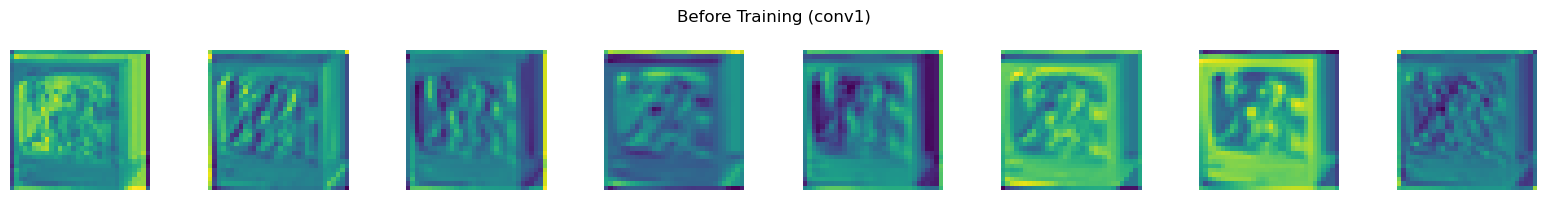

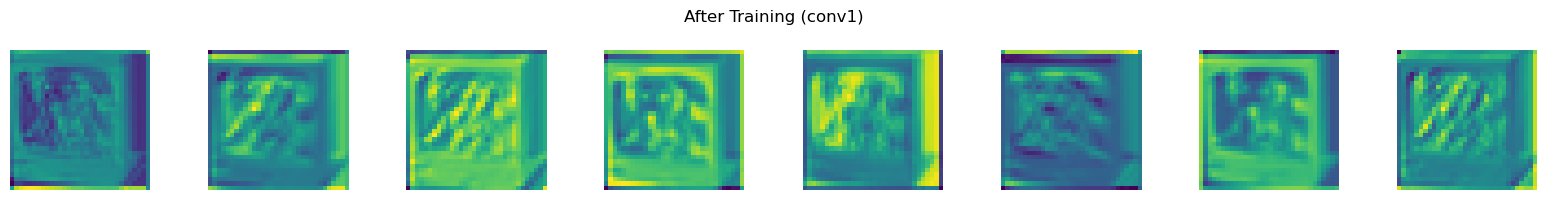

In [7]:
# --- Activation Map 비교 ---
sample_img = x_valid[23]
visualize_activation(model_before, sample_img, title="Before Training", layer="conv1")
visualize_activation(model_after, sample_img, title="After Training", layer="conv1")

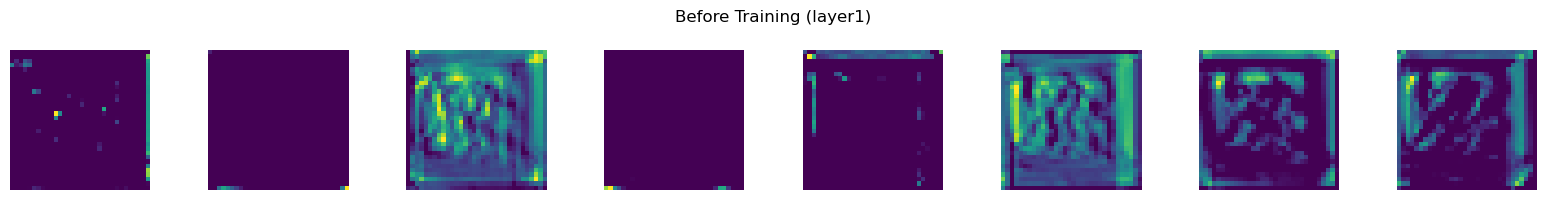

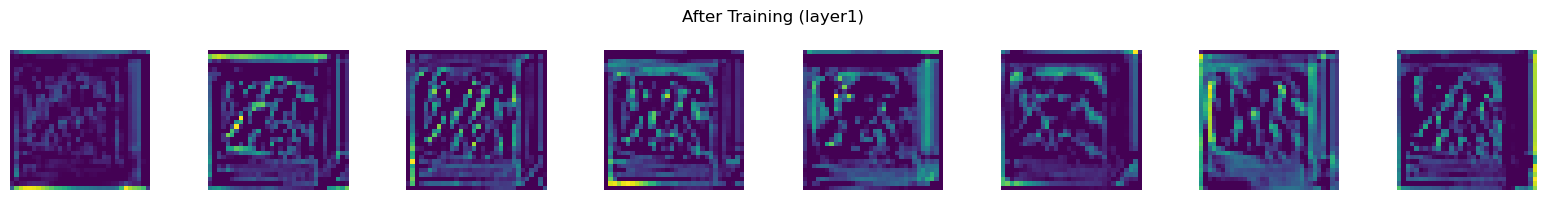

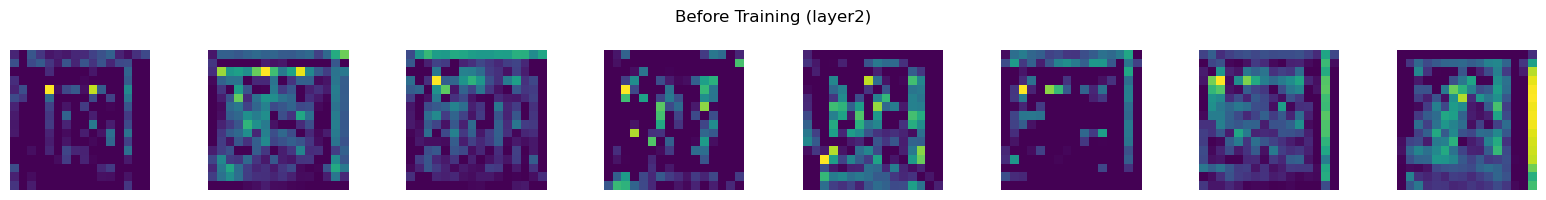

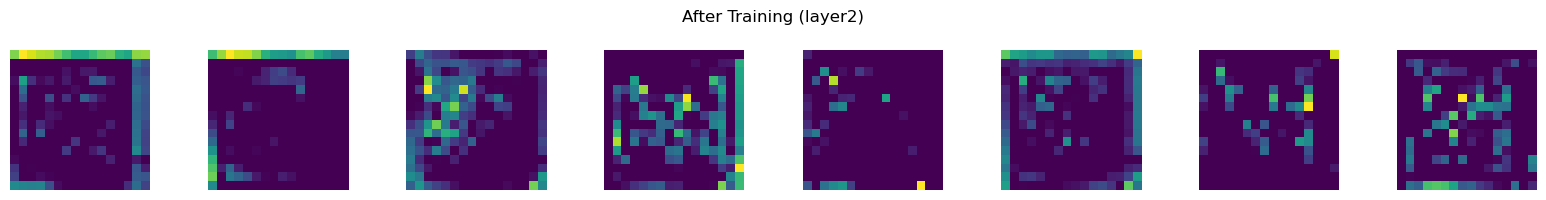

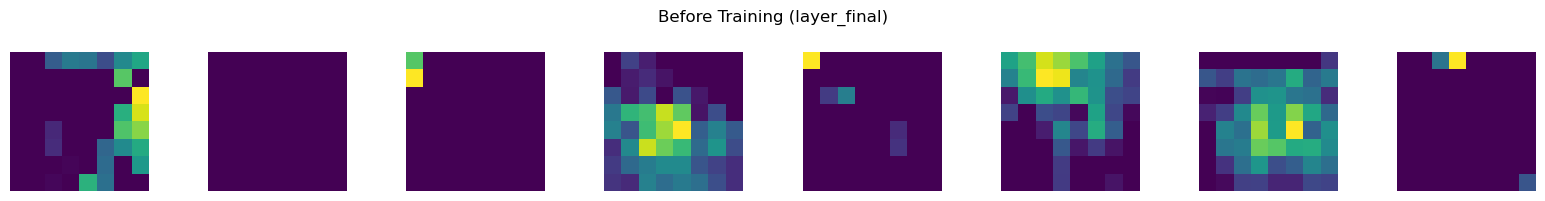

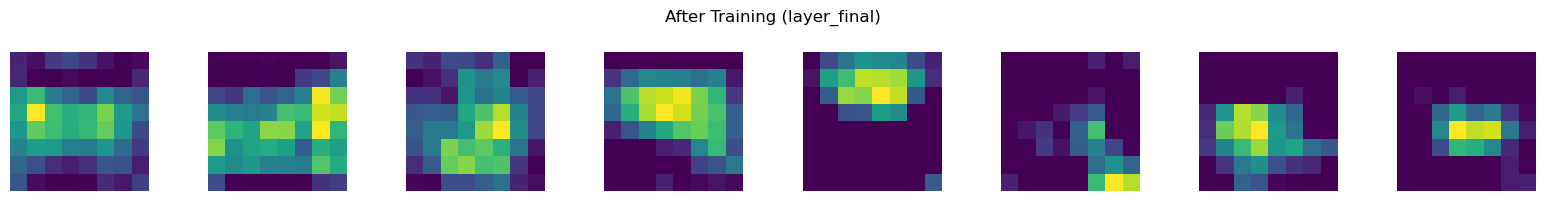

In [8]:
# --- Activation Map 비교 ---

visualize_activation(model_before, sample_img, title="Before Training", layer="layer1")
visualize_activation(model_after, sample_img, title="After Training", layer="layer1")

visualize_activation(model_before, sample_img, title="Before Training", layer="layer2")
visualize_activation(model_after, sample_img, title="After Training", layer="layer2")

visualize_activation(model_before, sample_img, title="Before Training", layer="layer_final")
visualize_activation(model_after, sample_img, title="After Training", layer="layer_final")

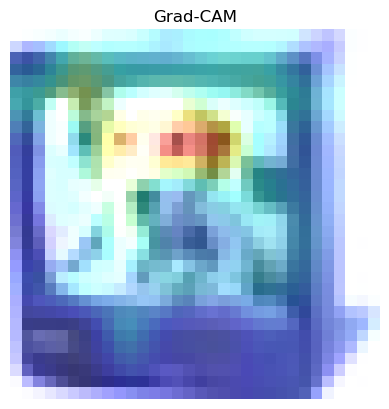

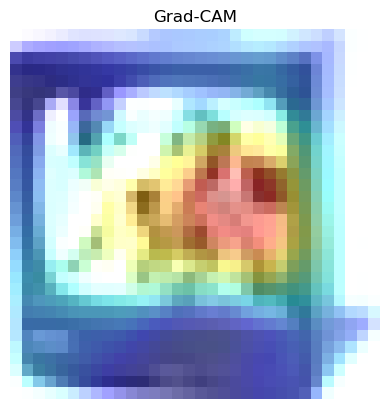

In [9]:
# --- Grad-CAM 비교 ---
label_idx = np.argmax(model_after.forward(sample_img[np.newaxis]))
gradcam_before = compute_gradcam(model_before, sample_img, label_idx)
gradcam_after = compute_gradcam(model_after, sample_img, label_idx)
visualize_gradcam(gradcam_before, sample_img)
visualize_gradcam(gradcam_after, sample_img)

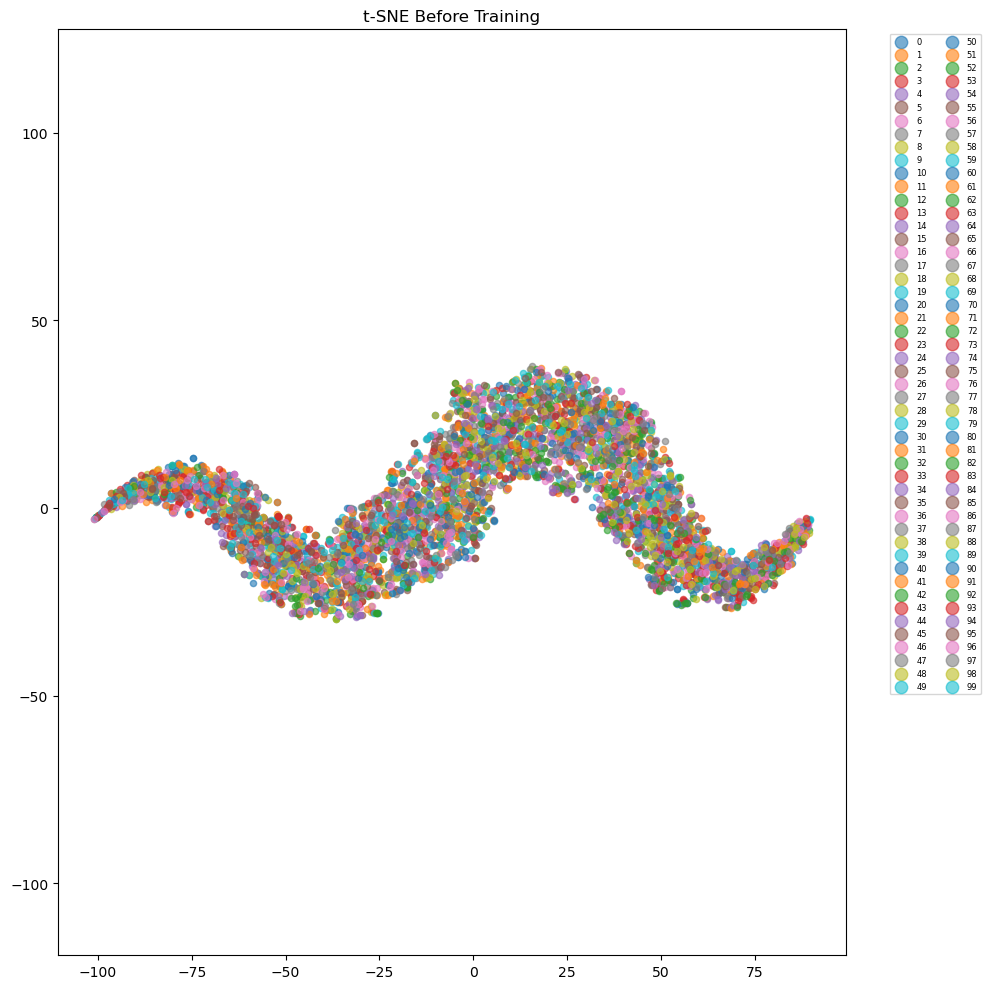

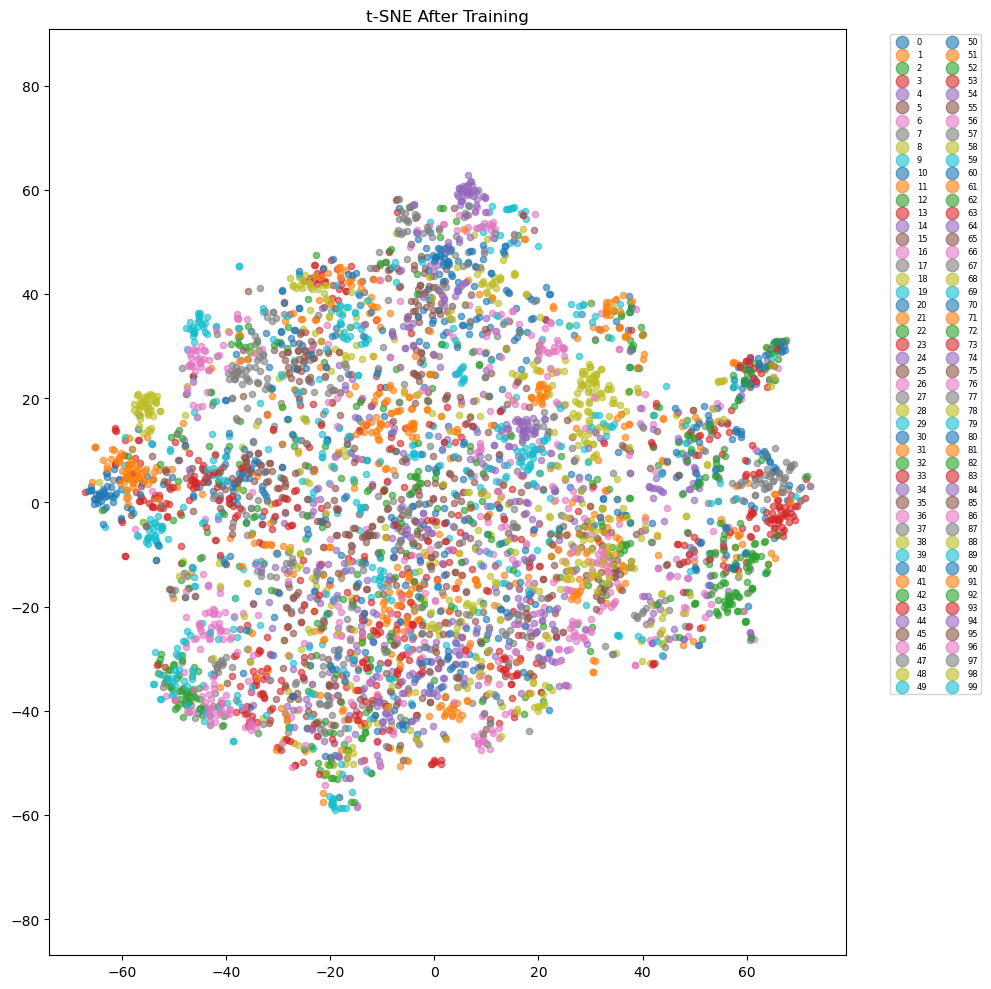

In [10]:
# --- t-SNE 비교 ---
x_val = x_valid
y_val = t_valid_fine
visualize_tsne(model_before, (x_val, y_val), title="t-SNE Before Training")
visualize_tsne(model_after, (x_val, y_val), title="t-SNE After Training")

In [15]:
def visualize_tsne_coarse(model, x_data, title="t-SNE (Coarse Label)"):
    from common.coarse_mapping import get_cifar100_fine_to_coarse_dict

    # 1. unpack
    x_input, fine_labels = x_data

    # 2. feature 추출
    features = []
    for i in range(0, len(x_input), 100):
        x_batch = x_input[i:i+100]
        _ = model.forward(x_batch, train_flg=False)
        features.append(model.pooled.copy())
    features = np.concatenate(features, axis=0)

    # 3. fine → coarse 매핑
    f2c = get_cifar100_fine_to_coarse_dict()
    coarse_labels = np.array([f2c[f] for f in fine_labels])

    # 4. t-SNE 수행
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    reduced = tsne.fit_transform(features)

    # 5. 시각화
    plt.figure(figsize=(10, 10))
    for i in range(20):
        idx = coarse_labels == i
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f"coarse {i}", alpha=0.6, s=20)
    plt.axis('equal')
    plt.title(title)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()


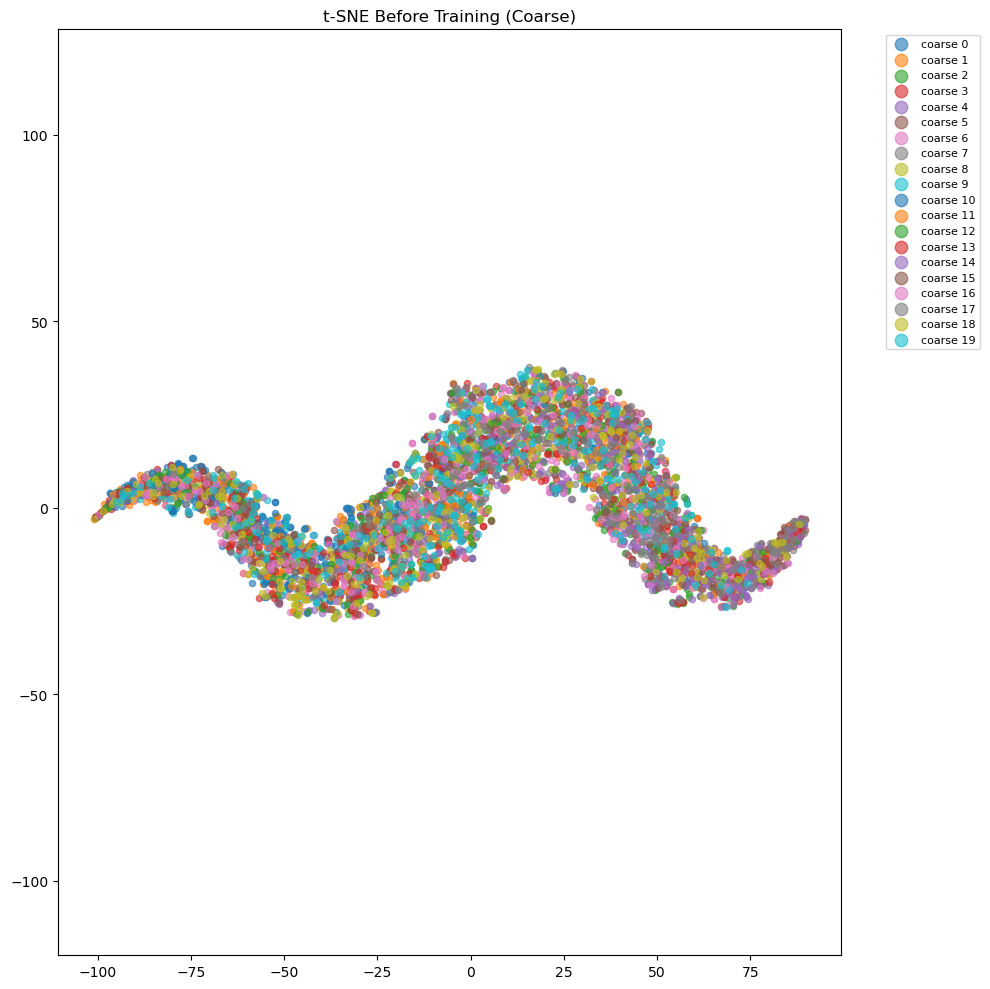

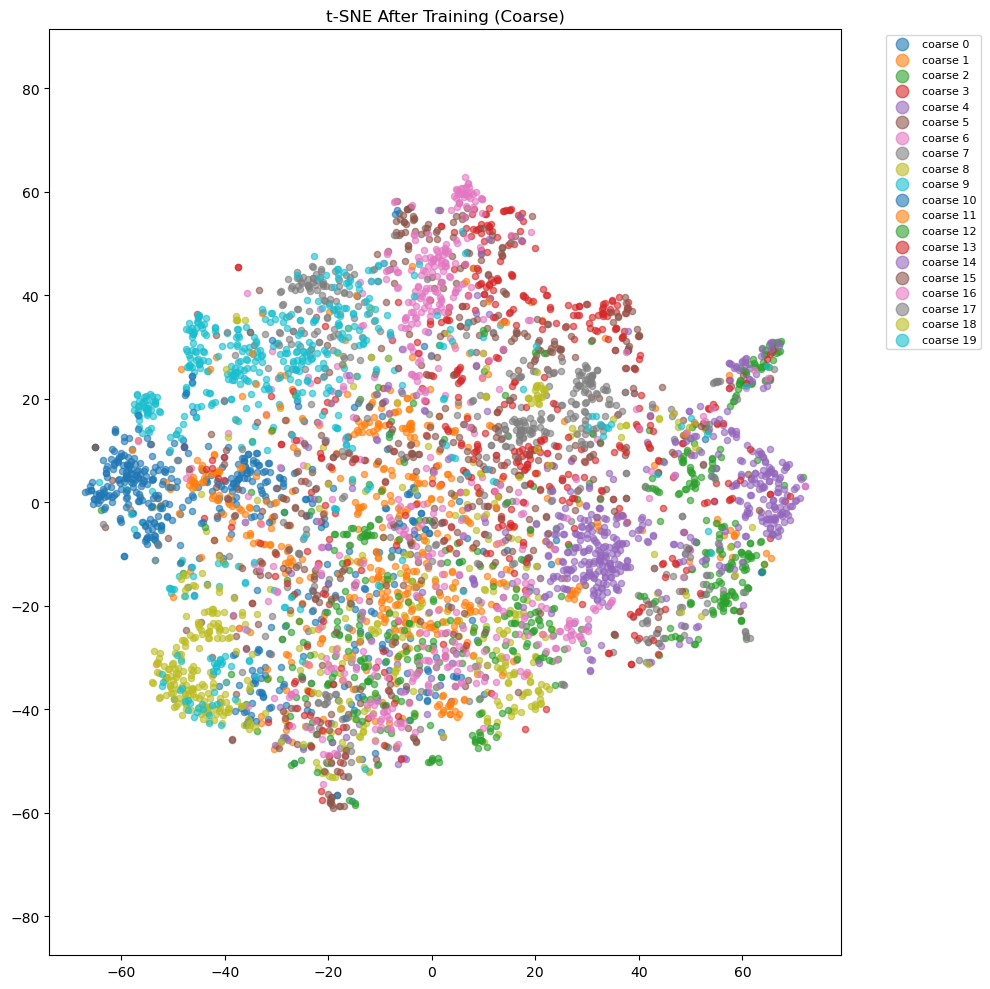

In [16]:
x_val = x_valid
y_val = t_valid_fine

visualize_tsne_coarse(model_before, (x_val, y_val), title="t-SNE Before Training (Coarse)")
visualize_tsne_coarse(model_after, (x_val, y_val), title="t-SNE After Training (Coarse)")

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from common.coarse_mapping import get_cifar100_fine_to_coarse_dict
from common.functions import softmax


def plot_confusion_matrix_sns(y_true, y_pred, num_classes, title, class_labels=None):

    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

    plt.figure(figsize=(7, 6))  # 더 넓은 그래프 영역 확보
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')

    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(title)

    # X/Y tick label 조정
    tick_freq = 10  # 10개 단위로만 라벨 표시
    ticks = np.arange(0, num_classes, tick_freq)
    labels = ticks if class_labels is None else [class_labels[i] for i in ticks]

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=90, fontsize=6)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels, fontsize=6)

    plt.tight_layout()
    plt.show()



In [26]:
# 1. 예측값 계산
logits = model_after.predict(x_test)                  # (N_test, 100)
probs = softmax(logits)
y_pred_fine = np.argmax(probs, axis=1)          # 예측 fine label
y_true_fine = t_test_fine                       # 정답 fine label

# 2. fine → coarse 매핑
f2c = get_cifar100_fine_to_coarse_dict()
y_pred_coarse = np.array([f2c[f] for f in y_pred_fine])
y_true_coarse = t_test_coarse  # 바로 사용 가능


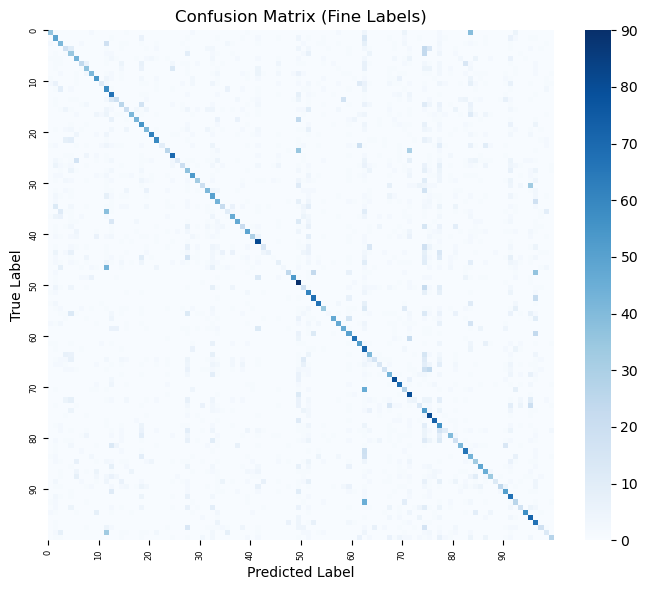

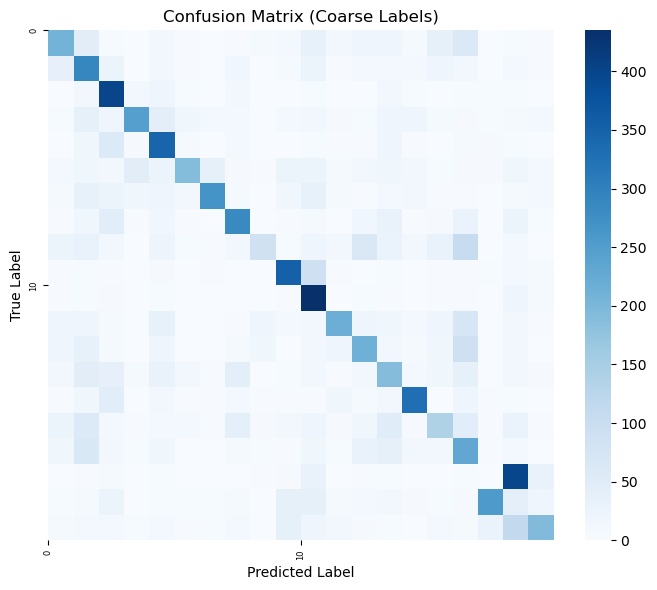

In [33]:
# 4. fine confusion matrix
plot_confusion_matrix_sns(
    y_true_fine, y_pred_fine, num_classes=100,
    title="Confusion Matrix (Fine Labels)"
)

# 5. coarse confusion matrix
plot_confusion_matrix_sns(
    y_true_coarse, y_pred_coarse, num_classes=20,
    title="Confusion Matrix (Coarse Labels)"
)

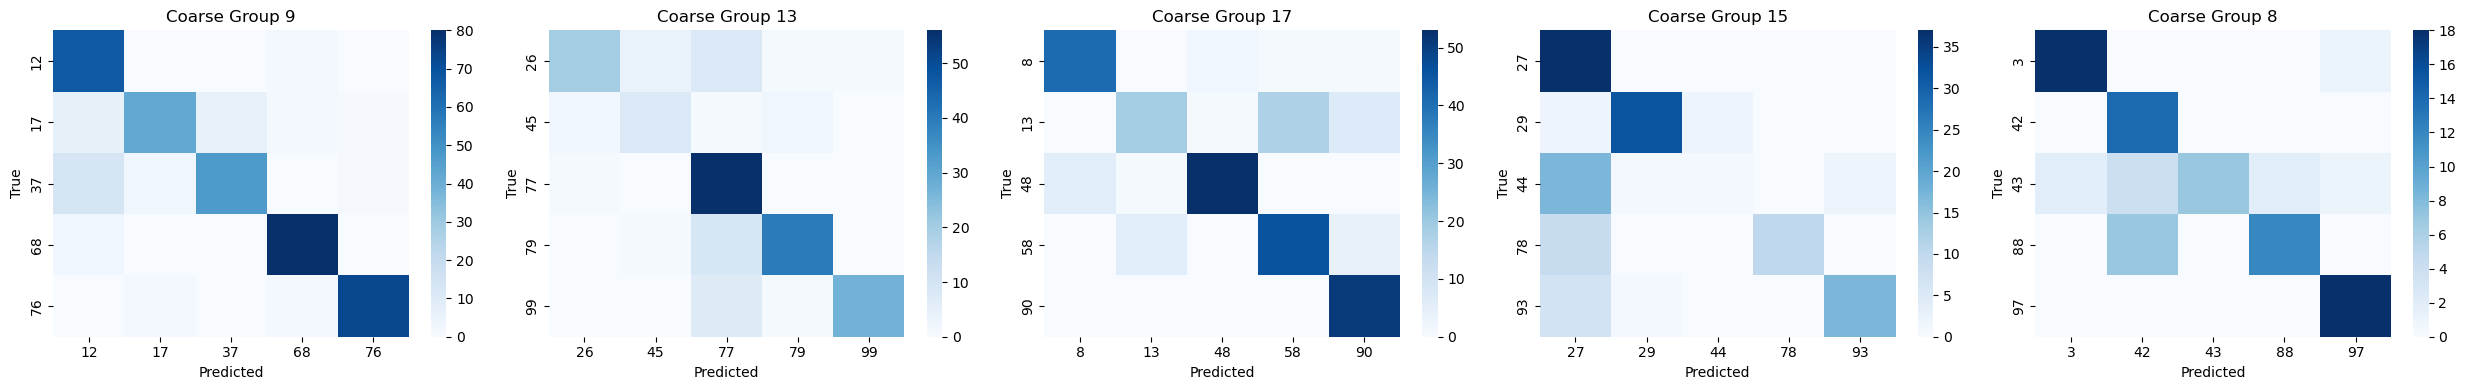

In [24]:
def plot_multiple_coarse_confusions(t_true_fine, y_pred_fine, group_ids, f2c):
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # fine → coarse 역변환
    coarse_to_fine = {}
    for fine, coarse in f2c.items():
        coarse_to_fine.setdefault(coarse, []).append(fine)

    num_groups = len(group_ids)
    fig, axes = plt.subplots(1, num_groups, figsize=(5 * num_groups, 4))

    for idx, coarse_id in enumerate(group_ids):
        fine_classes = coarse_to_fine[coarse_id]

        # 해당 coarse 그룹에 속한 샘플 필터링
        indices = [i for i, f in enumerate(t_true_fine) if f in fine_classes]
        filtered_true = [t_true_fine[i] for i in indices]
        filtered_pred = [y_pred_fine[i] for i in indices]

        # confusion matrix 계산
        cm = confusion_matrix(filtered_true, filtered_pred, labels=fine_classes)

        # 축 선택
        ax = axes[idx] if num_groups > 1 else axes
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=fine_classes, yticklabels=fine_classes, ax=ax)

        ax.set_title(f"Coarse Group {coarse_id}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    plt.tight_layout()
    plt.show()

# coarse group ID 5개 지정
group_ids = [9, 13, 17, 15, 8]

# 실행
plot_multiple_coarse_confusions(t_test_fine, y_pred_fine, group_ids, get_cifar100_fine_to_coarse_dict())
